1322
1322
(1322, 224, 224, 3)
(1322, 7, 7, 1)
Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.8808 - loss: 0.3991
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.9656 - loss: 0.1112
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 300s 906ms/step - accuracy: 0.9734 - loss: 0.0805
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 288s 871ms/step - accuracy: 0.9771 - loss: 0.0653
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 288s 870ms/step - accuracy: 0.9793 - loss: 0.0580
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 288s 871ms/step - accuracy: 0.9810 - loss: 0.0526
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 292s 881ms/step - accuracy: 0.9841 - loss: 0.0455
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 289s 874ms/step - accuracy: 0.9847 - loss: 0.0418
Epoch 9/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 290s 878ms/step - accuracy: 0.9867 - loss: 0.0372
Epoch 10/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 289s 872ms/step - accuracy: 0.9868 - loss: 0.0355


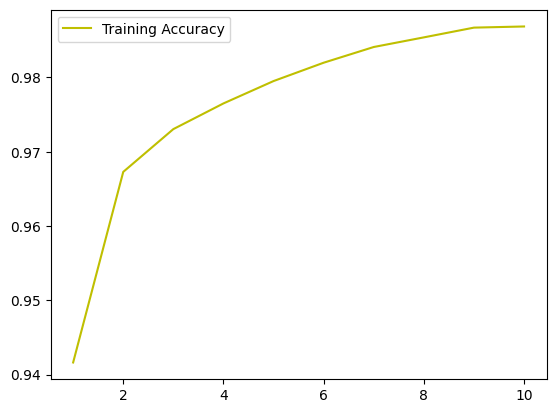

In [1]:
import os
# os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob

# Path to dataset
dataset_path = 'dataset/'

# Resize images
SIZE_X = 224
SIZE_Y = 224
OUTPUT_SIZE = (7, 7)  # Output size expected by the model

# Training images
train_images = []

# Iterate over image directories in the dataset
for subfolder_name in ['es_training', 'ed_training']:
    subfolder_path = os.path.join(dataset_path, "images", subfolder_name)
    # Iterate over image files in each subdirectory
    for img_path in glob.glob(os.path.join(subfolder_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_X, SIZE_Y))
        train_images.append(img)

train_images = np.array(train_images)
print(len(train_images))

# Training masks
train_masks = []

# Iterate over image directories in the dataset
for subfolder_name in ['es_training_gt', 'ed_training_gt']:
    subfolder_path = os.path.join(dataset_path, "mask", subfolder_name)
    # Iterate over image files in each subdirectory
    for mask_path in glob.glob(os.path.join(subfolder_path, "*.jpg")):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        mask = cv2.resize(mask, OUTPUT_SIZE)  # Resize mask to match output size
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        train_masks.append(mask)

train_masks = np.array(train_masks)

print(len(train_masks))

print(train_images.shape)
print(train_masks.shape)

# Preprocess input
train_images = tf.keras.applications.densenet.preprocess_input(train_images)

# Normalize mask values to range 0 to 3
train_masks = (train_masks / 255.0) * 3
train_masks = train_masks.astype('uint8')

# Convert masks to one-hot encoding
num_classes = 4
train_masks = tf.keras.utils.to_categorical(train_masks, num_classes=num_classes)

# Define model
densenet = DenseNet121(include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))
x = densenet.output
x = keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)
model = keras.models.Model(inputs=densenet.input, outputs=x)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=10e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Train model
history = model.fit(train_images,
                    train_masks,
                    batch_size=4,
                    epochs=10,
                    verbose=1)

# Plot Loss Graph
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.legend()
plt.show()

# Save model
model.save('model_segmentasi_jantung_densenet121.h5')

In [ ]:
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
import numpy as np

# Define the size of the input image
SIZE_X = 224
SIZE_Y = 224

# Load the model
model = tf.keras.models.load_model('model_segmentasi_jantung_densenet121.h5', compile=False)

# Load the test image
test_img = cv2.imread('dataset/images/es_training/0001-13.jpg')
test_img = cv2.resize(test_img, (SIZE_X, SIZE_Y))

# Display the original test image
plt.imshow(test_img, cmap='gray')
plt.show()

# Expand the dimensions of the test image to match the model input shape
test_img = np.expand_dims(test_img, axis=0)

# Perform prediction using the model
prediction = model.predict(test_img)

# Resize the prediction to match the original image size
prediction_resized = cv2.resize(prediction[0], (SIZE_X, SIZE_Y))

# Create a combined mask image with different colors for each mask
combined_mask = np.zeros((SIZE_X, SIZE_Y, 3))

# Assign RGB colors to each mask
combined_mask[:, :, 0] = prediction_resized[:, :, 0]  # Red channel for mask 1
combined_mask[:, :, 1] = prediction_resized[:, :, 1]  # Green channel for mask 2
combined_mask[:, :, 2] = prediction_resized[:, :, 2]  # Blue channel for mask 3

# Display the combined mask image
plt.imshow(combined_mask)
plt.title('Combined Mask Image')
plt.axis('off')  # Turn off axis labels
plt.show()
